In [1]:
import networkx as nx
import numpy as np
from pprint import pprint
from tqdm import tqdm
import random
import copy
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import pickle as pk
import os
import json
import seaborn as sns
import operator as op
from sklearn.compose import make_column_selector 

In [2]:
sns.set_theme()
# sns.set(font_scale = 2)

# Loading and preprocessing the data

In [3]:
data_path = "IMMIGRATION_data"
retrieved_data_path = "IMMIGRATION_retrieved_tweets"
output_path = "output"
annotation = "annotations"

In [4]:
# loading the conversations and aggregating the conversations
raw_conversations = []
for file in os.listdir("./../data/"+data_path+"/"):
    raw_conversations += (np.load("./../data/"+data_path+"/"+file,allow_pickle=True).tolist())

In [5]:
#Loading retrieved tweets 
retrieved_tweets = []
retrieved_tweets_path = "./../data/"+retrieved_data_path+"/"
retrieved_tweets = [json.load(open(retrieved_tweets_path+file)) for file in os.listdir(retrieved_tweets_path) if os.path.isfile(retrieved_tweets_path + file)]

In [6]:
#Elimiating the NA entries
conversations = [i for i in raw_conversations if i != "NA"]

# Making conversations out of the tweets

In [7]:
tweets_array = []
network_array = []
disconnected_tweets = []
disconnected_networks = []
disconnected_networks_nodes = {}

In [8]:
for conversation in tqdm(conversations):
    
    flag1, flag2 = False, False
    network = nx.DiGraph()
    conversation_id = None
    
    if "data" in conversation.keys():
        for tweet in conversation['data']:
            conversation_id = tweet["conversation_id"]
            source = tweet['id']
            if 'referenced_tweets' in tweet.keys():
                for reference in tweet['referenced_tweets']:
                    if reference['type'] == 'replied_to':
                        destination = reference['id']
                        network.add_edge(source, destination)
                        flag1=True
    
    if "includes" in conversation.keys():
        if "tweets" in conversation['includes'].keys():
            for tweet in conversation['includes']['tweets']:
                source = tweet['id']
                if 'referenced_tweets' in tweet.keys():
                    for reference in tweet['referenced_tweets']:
                        if reference['type'] == 'replied_to':
                            destination = reference['id']
                            network.add_edge(source, destination) 
                            flag2=True
    
    if (len(network.nodes) > 0) and (nx.is_connected(network.to_undirected())):
        if len(list(nx.simple_cycles(network)))>0:
            print("Directed cycle found")
        try:
            cycle_found = len(nx.find_cycle(network, orientation="ignore"))>0
            if cycle_found:
                print("Undirected cycle found")
        except:
            pass
    

    if (len(network.nodes) > 0) and (not nx.is_connected(network.to_undirected())):
        nodes = []
        disconnected_tweets.append(conversation)
        disconnected_networks.append(network)
        subgraphs=list(network.subgraph(c) for c in nx.connected_components(network.to_undirected()))
        for component in subgraphs:
            nodes.append(len(list(component.nodes)))
            if conversation_id not in list(component.nodes):
                for node in list(component.nodes):
                    if network.out_degree[node] == 0:
                        network.add_edge(node, conversation_id)
                        break
        disconnected_networks_nodes[len(conversation['data'])] =  disconnected_networks_nodes.get(len(conversation['data']), []) + [nodes]

                        
    if len(network.nodes) > 0 and conversation_id not in list(network.nodes):
        for node in list(network.nodes):
            if network.out_degree[node] == 0:
                network.add_edge(node, conversation_id)
                
                
    
    for node in network.nodes:
        if network.out_degree(node) > 1:
            print("Warning! There is a node with out_degree > 1")
    
    
    if flag1 or flag2:
        tweets_array.append(conversation)
        network_array.append(network)

100%|████████████████████████████████████████████████████████████████████████████| 1673/1673 [00:00<00:00, 1772.86it/s]


In [9]:
print("The number of conversations:", len(network_array))
print("The number of conversations with disconnected components:", len(disconnected_networks))

The number of conversations: 757
The number of conversations with disconnected components: 444


In [10]:
network_pairs = itertools.combinations(network_array,2)

similars = {}
equals = []
count = 0
big_graph = nx.DiGraph()
for pair in network_pairs:
    count += 1
    x = set(pair[0].nodes)
    y = set(pair[1].nodes)
    intersect = x.intersection(y)
    if x.issubset(y) and y.issubset(x):
        equals.append(pair) 
    elif len(intersect) != 0:
        similars[pair] = intersect   

for pair in similars:
    big_graph.add_edges_from(pair[0].edges)
    big_graph.add_edges_from(pair[1].edges)

In [11]:
print(len(similars), len(equals))

3 0


In [12]:
# After analysising the difference between the networks in the network_array and the components in the hyper graph, we concluded that there are 4 tweets that appear in more than one conversations
# Their tweet_ids are '1255223987153653760', '1255224509247954944', '1255234731467313154', '1255236472946515974'
# For better analysis check the two above cells as well as the bug fixing zone 
# The implication of this bried analysis is removing the conversations that have those 4 tweets

In [13]:
# We remove the networks from networks_array and recreat the hyper network
to_be_removed_network = set()
for pair in similars:
    to_be_removed_network.add(pair[0])
    to_be_removed_network.add(pair[1])
for pair in equals:
    to_be_removed_network.add(pair[0])
    to_be_removed_network.add(pair[1])

for i in to_be_removed_network:
    network_array.remove(i)

In [14]:
hyper_network = nx.DiGraph()
for graph in network_array:
    hyper_network.add_edges_from(graph.edges)

In [15]:
print(len(network_array), nx.number_connected_components(hyper_network.to_undirected()))

751 751


In [16]:
nx.write_gexf(hyper_network, path="./../"+output_path+"/networks_gexf/"+"_conversations_raw.gexf")

In [17]:
nodes = set()
for net in network_array:
    for node in list(net.nodes):
        nodes.add(node)

# Text and author extraction from the tweets

In [18]:
tweet_text = {tweet_id:None for tweet_id in nodes}
tweet_author = {tweet_id:None for tweet_id in nodes}

for conversation in tqdm(conversations):
    if "data" in conversation.keys(): 
        for tweet in conversation['data']:
            tweet_text[tweet["id"]] = tweet["text"]
            tweet_author[tweet["id"]] = tweet['author_id']

    if "includes" in conversation.keys():
        if 'tweet' in conversation['includes']:
            for tweet in conversation['includes']['tweets']:
                tweet_text[tweet["id"]] = tweet["text"]
                tweet_author[tweet["id"]] = tweet['author_id']

100%|██████████████████████████████████████████████████████████████████████████| 1673/1673 [00:00<00:00, 108920.13it/s]


In [19]:
sum([1 for i,j in tweet_text.items() if j is None])

5978

In [20]:
#Adding retrieved tweets to the tweet_text for the annotation
for tweet in retrieved_tweets:
    if tweet["id_str"] in nodes:
        tweet_text[tweet["id_str"]] = tweet["full_text"]
        tweet_author[tweet["id_str"]] = tweet["user"]["id_str"]

In [21]:
#I will change the id of tweet_authors with None as user value to a negative number becasue if all the users have None as a username, they will be treated as a smae node in the network
number = 0
count = -1
for tweet_id , author_id in tweet_author.items():
    if author_id is None:
        number += 1
        tweet_author[tweet_id] = count
        count -= 1

In [23]:
df = pd.DataFrame.from_dict(tweet_text, orient="index", columns=["text"])
df.to_csv("./../"+output_path+"/csv/"+"_tweet_text.csv")

In [24]:
no_text_tweets = {i for i,j in tweet_text.items() if j is None}

In [25]:
print(len(no_text_tweets), number)

3107 3107


In [26]:
# # Finding the tweets without text or author that should be retrieved from Twitter API

# to_be_retrieved_tweets = set()

# for tweet_id, text in tqdm(tweet_text.items()):
#     if text == None:
#         to_be_retrieved_tweets.add(tweet_id)
# print(len(to_be_retrieved_tweets))

# for tweet_id, author_id in tqdm(tweet_author.items()):
#     if type(author_id)!=str and author_id<0 :
#         to_be_retrieved_tweets.add(tweet_id)
# print(len(to_be_retrieved_tweets))


# pk.dump(to_be_retrieved_tweets, open("./pickles/"+subject+"_tweet_ids_for retreival.list", "wb"))

# Making a tweet-label dictionary

In [27]:
#comparing new and old annotation files
old_ds = pd.read_csv("./../"+annotation+"/IMMIGRATION_conversation_with_viewpoint.csv")
new_ds = pd.read_csv("./../"+annotation+"/conversation_with_incivility_intolerance_8columns.csv")

old_ds_list = list(old_ds["tweet_id"])
old_ds_set = set(old_ds_list)

new_ds_list = list(new_ds["tweet_id"])
new_ds_set = set(new_ds_list)

print(len(old_ds_list), len(old_ds_set), len(new_ds_list), len(new_ds_set))

print(len(old_ds_set.intersection(new_ds_set)))
lefts = [str(i) for i in new_ds_list if i not in old_ds_list]
print(len(lefts))

25042 25042 25131 25131
25042
89


In [28]:
vp_ds_raw = pd.read_csv("./../"+annotation+"/IMMIGRATION_conversation_with_viewpoint.csv")
inc_ds_raw = pd.read_csv("./../"+annotation+"/conversation_with_incivility_intolerance_8columns.csv")

In [29]:
vp_df = vp_ds_raw[["tweet_id", "relevance", "viewpoint"]]
vp_df['tweet_id'] = vp_df['tweet_id'].astype('str')
vp_df = vp_df.loc[~vp_df['tweet_id'].isin(no_text_tweets)]
for col in ["relevance", "viewpoint"]:
    vp_df.loc[:][col] = vp_df.loc[:][col].str.strip()
vp_df.index = vp_df["tweet_id"].index = vp_df["tweet_id"]
    
inc_df = inc_ds_raw[["tweet_id", "profanity", "insults", "char. assn.", "outrage", "incivility"]]
inc_df['tweet_id'] = inc_df['tweet_id'].astype('str')
inc_df.index = inc_df["tweet_id"].index = inc_df["tweet_id"]

C:\Users\P70076~1\AppData\Local\Temp/ipykernel_14292/992247260.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vp_df['tweet_id'] = vp_df['tweet_id'].astype('str')
C:\Users\P70076~1\AppData\Local\Temp/ipykernel_14292/992247260.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inc_df['tweet_id'] = inc_df['tweet_id'].astype('str')


In [30]:
annotation_dict = {"tweet_id":{}, "relevance":{}, "viewpoint":{}, "profanity":{}, "insults":{}, "char. assn.":{}, "outrage":{}, "incivility":{}}
tweet_ids = list(vp_df["tweet_id"])

In [31]:
for twt_id in tqdm(tweet_ids):
    annotation_dict["tweet_id"][twt_id] = twt_id
    annotation_dict["relevance"][twt_id] = vp_df.loc[twt_id]["relevance"]
    annotation_dict["viewpoint"][twt_id] = vp_df.loc[twt_id]["viewpoint"]
    annotation_dict["profanity"][twt_id] = inc_df.loc[twt_id]["profanity"]
    annotation_dict["insults"][twt_id] = inc_df.loc[twt_id]["insults"]
    annotation_dict["char. assn."][twt_id] = inc_df.loc[twt_id]["char. assn."]
    annotation_dict["outrage"][twt_id] = inc_df.loc[twt_id]["outrage"]
    annotation_dict["incivility"][twt_id] = inc_df.loc[twt_id]["incivility"]

100%|██████████████████████████████████████████████████████████████████████████| 21935/21935 [00:13<00:00, 1669.70it/s]


In [32]:
annotation_df = pd.DataFrame(annotation_dict)

In [33]:
# #Loading the annotations
# annotated_tweets = pd.read_csv("./../"+annotation+"/conversation_with_incivility_intolerance_8columns.csv")

In [34]:
# selected_columns = [i for i in annotated_tweets.columns if i not in ['Unnamed: 0', 'text']]
# annotated_df = annotated_tweets[selected_columns]
# annotated_df['tweet_id'] = annotated_df['tweet_id'].astype('str')
# annotated_df2 = annotated_df.loc[~annotated_df["tweet_id"].isin(lefts)]
# annotation_df = annotated_df2.loc[~annotated_df2['tweet_id'].isin(no_text_tweets)]
# for col in ["relevance", "viewpoint"]:
#     annotation_df.loc[:][col] = annotation_df.loc[:][col].str.strip()

In [35]:
# print(len(annotated_df), len(annotated_df2), len(annotation_df), len(annotated_df2)-len(annotation_df))

In [36]:
# 25131 (len(annotation_df)) - 21994 (len(annotation_df)) = 3137 (which is equal to the number of tweets without the text)

In [37]:
print(list(annotation_df['relevance'].unique()), list(annotation_df['viewpoint'].unique()))

['no', 'not english', 'yes'] ['none', nan, 'diagnostic', 'counter']


In [38]:
not_english_df = annotation_df.loc[annotation_df["relevance"]=='not english']

In [39]:
annotation_df_no_englsih = annotation_df.drop(axis='index', index=not_english_df.index)

In [40]:
# len(annotation_df) - len(not_english_df)

In [41]:
annotation_dict = pd.DataFrame.to_dict(annotation_df_no_englsih)
annotation_dict["label"] = {i:None for i in annotation_dict["tweet_id"].keys()}

In [42]:
for index, relevance in annotation_dict["relevance"].items():
    if relevance == "no":
        annotation_dict["label"][index] = "L1"
    elif relevance == "yes":
        if annotation_dict["viewpoint"][index] == "none":
            annotation_dict["label"][index] = "L2"
        elif annotation_dict["viewpoint"][index] == "diagnostic":
            annotation_dict["label"][index] = "L3"
        elif annotation_dict["viewpoint"][index] == "counter":
            annotation_dict["label"][index] = "L4"

In [43]:
annotated_tweets_df = pd.DataFrame.from_dict(annotation_dict)
cols = [i for i in annotated_tweets_df if i not in ['relevance', 'viewpoint']]
annotated_tweets_df = annotated_tweets_df[cols]
annotated_tweets_df.index = annotated_tweets_df["tweet_id"]

In [44]:
annotated_tweets_dict = pd.DataFrame.to_dict(annotated_tweets_df)

# Removing the tweets (without text and non-english ones) from the conversations

In [45]:
print(len(not_english_df) , len(no_text_tweets))

2487 3107


In [46]:
not_english_records = set(list(not_english_df['tweet_id'].values))

In [47]:
to_be_removed_tweets = no_text_tweets.union(not_english_records)

In [48]:
len(to_be_removed_tweets)

5594

In [49]:
modified_network_array = []
zeros, ones = [], []


for network in tqdm(network_array): 
    flag = True
    under_operation_network = copy.deepcopy(network)
    nodes_list = network.nodes
    
    for node in nodes_list:
        if node in to_be_removed_tweets:
            if under_operation_network.out_degree(node) == 0:
                if under_operation_network.in_degree(node) <= 1:
                    under_operation_network.remove_node(node)
                elif under_operation_network.in_degree(node) > 1:
                    in_edges = list(under_operation_network.in_edges(node))
                    new_root = in_edges[0][0]
                    for elm in in_edges:
                        if new_root not in elm: 
                            under_operation_network.add_edge(elm[0], new_root)
                    under_operation_network.remove_node(node)
                            
            elif under_operation_network.out_degree(node) == 1:
                if under_operation_network.in_degree(node) == 0:
                    under_operation_network.remove_node(node)
                elif under_operation_network.in_degree(node) >= 1:
                    in_edges = list(under_operation_network.in_edges(node))
                    for elm in in_edges:
                        under_operation_network.add_edge(elm[0], list(under_operation_network.out_edges(node))[0][1])
                    under_operation_network.remove_node(node)
                    
    net_size = len(under_operation_network.nodes) 
    if net_size == 0:
        zeros.append(under_operation_network)
        flag = False
    elif net_size == 1:
        ones.append(under_operation_network)
        flag = False
        

        
    if (len(under_operation_network.nodes) > 0) and (nx.is_connected(under_operation_network.to_undirected())):
        if len(list(nx.simple_cycles(under_operation_network)))>0:
            print("Directed cycle found")
        try:
            cycle_found = len(nx.find_cycle(under_operation_network, orientation="ignore"))>0
            if cycle_found:
                print("Undirected cycle found")
        except:
            pass
    
    if (len(under_operation_network.nodes) > 0) and (not nx.is_connected(under_operation_network.to_undirected())):
        print("the network is disconnected")                        
                
    for node in under_operation_network.nodes:
        if under_operation_network.out_degree(node) > 1:
            print("Warning! node with out-degree>1 is found")
    
    # if (len(under_operation_network.nodes) < 3): #Getting rid of networks with the size of tw
    #     flag = False
        
    
    if flag:
        modified_network_array.append(under_operation_network)

100%|███████████████████████████████████████████████████████████████████████████████| 751/751 [00:01<00:00, 592.49it/s]


In [50]:
modified_hyper_network = nx.DiGraph()
for graph in modified_network_array:
    modified_hyper_network.add_edges_from(graph.edges)

In [51]:
print(len(network_array), nx.number_connected_components(hyper_network.to_undirected()),  len(modified_network_array), nx.number_connected_components(modified_hyper_network.to_undirected()))

751 751 664 664


In [52]:
nx.write_gexf(modified_hyper_network, path="./../"+output_path+"/networks_gexf/"+"_conversations_modified.gexf")

<!-- # Adding some properties to the modified network nodes -->

# Removing enitirely irrelevant conversations networks

In [53]:
for network in tqdm(modified_network_array):
    for node in network.nodes:
        network.nodes[node]["text"] = tweet_text[node]
        network.nodes[node]["annotation"] = annotated_tweets_df.loc[node]['label']

100%|███████████████████████████████████████████████████████████████████████████████| 664/664 [00:01<00:00, 355.43it/s]


In [54]:
relevant_network_array = []
for network in modified_network_array:
    flag = False
    for node in network.nodes:
        if network.nodes[node]["annotation"] != "L1":
            flag = True
            break
    if flag:
        relevant_network_array.append(network)

In [55]:
print(len(modified_network_array), len(relevant_network_array))

664 412


In [56]:
# removing single authored conversations
related_network_array = []
for network in relevant_network_array:
    authors = set()
    flag = False
    for node in network.nodes:
        authors.add(tweet_author[node])
        if len(authors) > 1:
            flag = True
            break
    if flag:
        related_network_array.append(network)

In [57]:
print(len(relevant_network_array), len(related_network_array))

412 366


In [58]:
relevant_modified_hyper_network_with_attributes = nx.DiGraph()
for graph in related_network_array:
    relevant_modified_hyper_network_with_attributes.add_nodes_from(graph.nodes)
    relevant_modified_hyper_network_with_attributes.add_edges_from(graph.edges)

In [59]:
conv_vps, conv_inc = {},{}
conv_id = 0
subgraphs=list(relevant_modified_hyper_network_with_attributes.subgraph(c) for c in nx.connected_components(relevant_modified_hyper_network_with_attributes.to_undirected()))
for component in tqdm(subgraphs):
    conv_vps[conv_id] = []
    conv_inc[conv_id] = []
    for node in list(component.nodes):
        component.nodes[node]['profanity'] = annotated_tweets_df.loc[node]['profanity']
        component.nodes[node]['insults'] = annotated_tweets_df.loc[node]['insults']
        component.nodes[node]['char. assn.'] = annotated_tweets_df.loc[node]['char. assn.']
        component.nodes[node]['outrage'] = annotated_tweets_df.loc[node]['outrage']
        # component.nodes[node]['L2_intolerance'] = annotated_tweets_df.loc[node]['L2_intolerance']
        # component.nodes[node]['discrimination'] = annotated_tweets_df.loc[node]['discrimination']
        # component.nodes[node]['intolerance'] = annotated_tweets_df.loc[node]['intolerance']
        component.nodes[node]['incivility'] = annotated_tweets_df.loc[node]['incivility']
        component.nodes[node]['label'] = annotated_tweets_df.loc[node]['label']
        component.nodes[node]['tweet_id'] = annotated_tweets_df.loc[node]['tweet_id']
        component.nodes[node]['conv_id'] = conv_id
        
        # inc_lbl = "inc" if annotated_tweets_dict['incivility'][node] == 1 else "civ"
        # int_lbl = "int" if annotated_tweets_dict['intolerance'][node] == 1 else "tol"
        # node_lbl = inc_lbl + " and " + int_lbl 
        # component.nodes[node]['inc_int_lbl'] = node_lbl
        
        conv_vps[conv_id].append(annotated_tweets_df.loc[node]['label'])
        conv_inc[conv_id].append(annotated_tweets_df.loc[node]['incivility'])
    conv_id += 1

100%|████████████████████████████████████████████████████████████████████████████████| 366/366 [00:10<00:00, 36.29it/s]


In [60]:
nx.number_connected_components(relevant_modified_hyper_network_with_attributes.to_undirected())

366

In [61]:
nx.write_gexf(relevant_modified_hyper_network_with_attributes, path="./../"+output_path+"/networks_gexf/"+"_conversations_relevant_modified_with_attributes.gexf")

In [62]:
pk.dump(conv_vps, open("./../"+output_path+"/pickles/"+"convs_vps.pk", "wb"))
pk.dump(conv_inc, open("./../"+output_path+"/pickles/"+"conv_inc.pk", "wb"))

In [ ]:
# # Collecting irrelevant tweets to pass to the third model for geeting the label
# irrelevant_tweets_in_relevant_conversations = {}

# for net in related_network_array:
#     for node in net.nodes:
#         if net.nodes[node]["annotation"] == "L1":
#             irrelevant_tweets_in_relevant_conversations[node] = net.nodes[node]["text"]
            
# pk.dump(irrelevant_tweets_in_relevant_conversations, open("./pickles/"+subject+"_irrelevant_tweets_in_relevant_conversations.pk", "wb"))

In [64]:
len(conv_vps)

366

### Conversation level details

In [ ]:
### Conversation level details
conv_det = {}
conversations=list(relevant_modified_hyper_network_with_attributes.subgraph(c) for c in nx.connected_components(relevant_modified_hyper_network_with_attributes.to_undirected()))
print(len(conversations))
for conv_id, conv in tqdm(enumerate(conversations)):
    conv_det[conv_id] = {}
    conv_det[conv_id]["labels"] = {}
    conv_det[conv_id]["size"] = len(conv.nodes)
    conv_det[conv_id]["depth"] = None
    conv_det[conv_id]["authors"] = []
    conv_det[conv_id]["authors_count"] = None
    conv_det[conv_id]["distinct_authors_count"] = None
    conv_det[conv_id]["WI"] = None
    conv_det[conv_id]["conversation_graph"] = conv
    conv_det[conv_id]["root_node"] = None
    conv_det[conv_id]["root_node_label"] = None
    
    conv_det[conv_id]['profanity'] = []
    conv_det[conv_id]['insults'] = []
    conv_det[conv_id]['char. assn.'] = []
    conv_det[conv_id]['outrage'] = []
    conv_det[conv_id]['L2_intolerance'] = []
    conv_det[conv_id]['discrimination'] = []
    conv_det[conv_id]['intolerance'] = []
    conv_det[conv_id]['incivility'] = []
    conv_det[conv_id]['annotation'] = []
    conv_det[conv_id]['tweet_id'] = []


    for n,d in dict(conv.out_degree).items():
        if d == 0:
            conv_det[conv_id]["root_node"] = n
            conv_det[conv_id]["root_node_label"] = annotated_tweets_df.loc[n]["label"]
            break   

    for node in conv.nodes:
        ###
        conv_det[conv_id]['profanity'].append(annotated_tweets_df.loc[node]['profanity'])
        conv_det[conv_id]['insults'].append(annotated_tweets_df.loc[node]['insults'])
        conv_det[conv_id]['char. assn.'].append(annotated_tweets_df.loc[node]['char. assn.'])
        conv_det[conv_id]['outrage'].append(annotated_tweets_df.loc[node]['outrage'])
        conv_det[conv_id]['L2_intolerance'].append(annotated_tweets_df.loc[node]['L2_intolerance'])
        conv_det[conv_id]['discrimination'].append(annotated_tweets_df.loc[node]['discrimination'])
        conv_det[conv_id]['intolerance'].append(annotated_tweets_df.loc[node]['intolerance'])
        conv_det[conv_id]['incivility'].append(annotated_tweets_df.loc[node]['incivility'])
        conv_det[conv_id]['tweet_id'].append(annotated_tweets_df.loc[node]['tweet_id'])
        ###
        label = annotated_tweets_df.loc[node]["label"]
        conv_det[conv_id]["labels"][label] = conv_det[conv_id]["labels"].get(label, 0) + 1
        conv_det[conv_id]["authors"].append(tweet_author[node])
    conv_det[conv_id]["authors_count"] = len(conv_det[conv_id]["authors"])
    conv_det[conv_id]["distinct_authors_count"] = len(set(conv_det[conv_id]["authors"]))

    max_path = 0
    leaves = []
    paths = []
    for node in conv.nodes:
        if conv.out_degree(node) == 0:
            root = node
        elif conv.in_degree(node) == 0:
            leaves.append(node)
    for leaf in leaves:
        paths.append(len([i for i in nx.shortest_simple_paths(conv, leaf, root)][0])-1)
        max_path = np.max(paths)
    conv_det[conv_id]["depth"] = max_path

    node_size = len(conv.nodes())
    conv_det[conv_id]["WI"] = nx.algorithms.wiener.wiener_index(conv.to_undirected(())) / ((node_size*(node_size-1))/2)        

# Descriptives

In [53]:
selector = make_column_selector(dtype_exclude=object)
numeric_columns = selector(annotated_tweets_df)
annotated_tweets_df_numeric = annotated_tweets_df[numeric_columns]

In [54]:
# Frequency and fraction of incivility/intolerance labels

inc_int_freq = dict(annotated_tweets_df_numeric.sum())
_inc_int_freq = {i:[j] for i,j in inc_int_freq.items()}
inc_int_frac = dict(annotated_tweets_df_numeric.sum()/len(annotated_tweets_df_numeric))
_inc_int_frac = {p:[q] for p,q in inc_int_frac.items()}

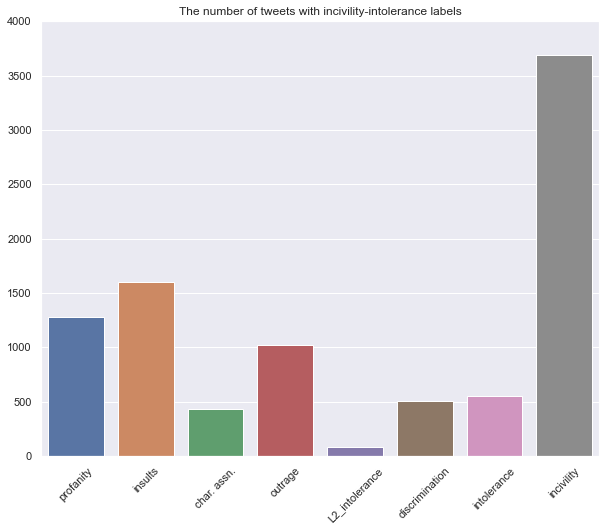

In [55]:
sns.light_palette("seagreen", as_cmap=True)
fig, ax = plt.subplots(figsize=(10,8))
chart = sns.barplot(data=pd.DataFrame.from_dict(_inc_int_freq))

ax.set_ylim(top=4000)
# plt.xticks(rotation=30, ha='right')
ax.set_title("The number of tweets with incivility-intolerance labels")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.savefig("./../"+output_path+"/figures/"+"_tweet_number_inc_int.png", bbox_inches="tight")
plt.show()

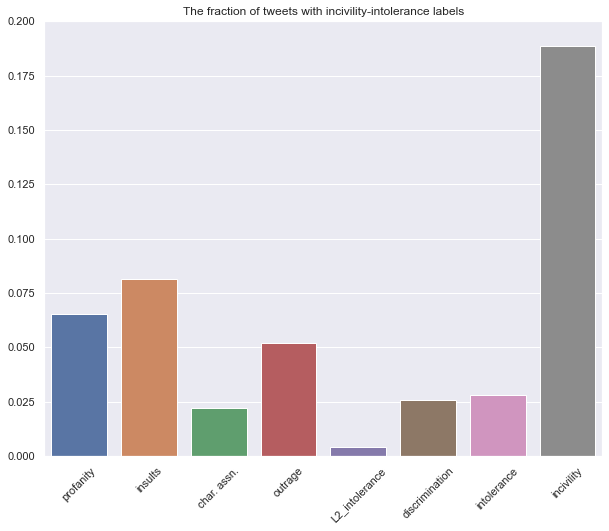

In [56]:
sns.light_palette("seagreen", as_cmap=True)
fig, ax = plt.subplots(figsize=(10,8))
chart = sns.barplot(data=pd.DataFrame.from_dict(_inc_int_frac))

ax.set_ylim(top=0.2)
# plt.xticks(rotation=30, ha='right')
ax.set_title("The fraction of tweets with incivility-intolerance labels")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.savefig("./../"+output_path+"/figures/"+"_tweet_frac_inc_int.png", bbox_inches="tight")
plt.show()

In [57]:
annotated_tweets_dict = pd.DataFrame.to_dict(annotated_tweets_df)

In [58]:
inc_int_lbl_overlap_dict = {}
inc_int_columns = list(annotated_tweets_df_numeric.columns)
for col in inc_int_columns:
    inc_int_lbl_overlap_dict[col] = {"L1":0, "L2":0, "L3":0, "L4":0}

In [59]:
for twt_id in annotated_tweets_dict['tweet_id']:
    twt_lbl = annotated_tweets_dict['label'][twt_id]
    
    for catg in inc_int_columns:
        inc_int_lbl_overlap_dict[catg][twt_lbl] +=  annotated_tweets_dict[catg][twt_id]

inc_int_lbl_overlap_df = pd.DataFrame.from_dict(inc_int_lbl_overlap_dict)

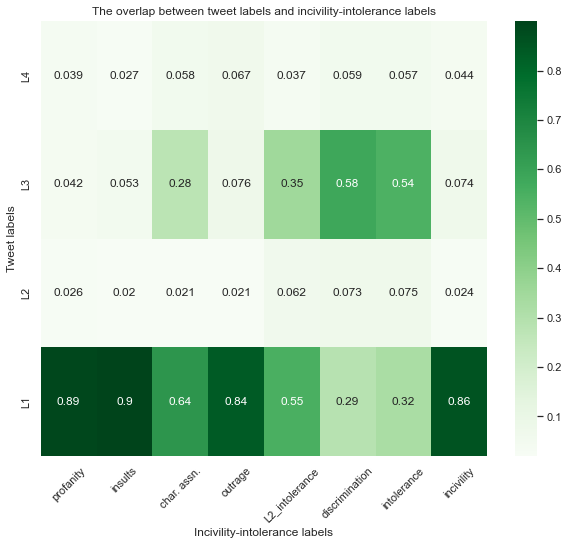

In [60]:
fig, ax = plt.subplots(figsize=(10,8)) 
ax = sns.heatmap(inc_int_lbl_overlap_df/inc_int_lbl_overlap_df.sum(), annot=True, cmap="Greens", fmt='.2g')
ax.invert_yaxis()
plt.xlabel("Incivility-intolerance labels")
plt.ylabel("Tweet labels")
ax.set_title("The overlap between tweet labels and incivility-intolerance labels")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.savefig("./../"+output_path+"/figures/"+"_tweet_frac_inc_int_lbl.png", bbox_inches="tight")
plt.show()

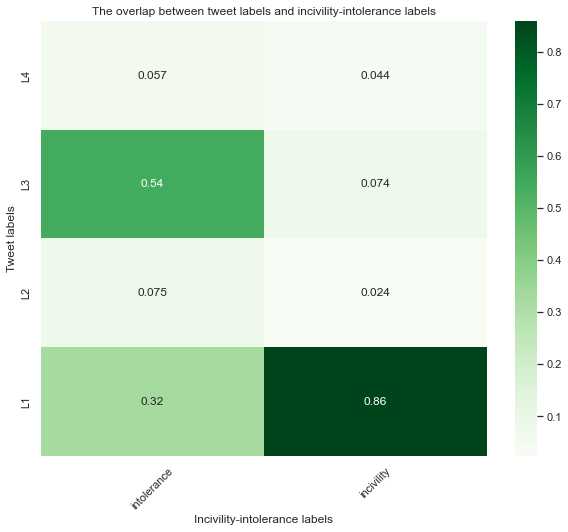

In [61]:
fig, ax = plt.subplots(figsize=(10,8)) 
selected_columns = ['intolerance', 'incivility']
ax = sns.heatmap(inc_int_lbl_overlap_df[selected_columns]/inc_int_lbl_overlap_df[selected_columns].sum(), annot=True, cmap="Greens", fmt='.2g')
ax.invert_yaxis()
plt.xlabel("Incivility-intolerance labels")
plt.ylabel("Tweet labels")
ax.set_title("The overlap between tweet labels and incivility-intolerance labels")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.savefig("./../"+output_path+"/figures/"+"_tweet_frac_inc_int_lbl_(only_inc_int).png", bbox_inches="tight")
plt.show()

In [62]:
inc_int_len_siz_dict = {}
for conv_id2, conv2 in conv_det.items():
    inc_int_len_siz_dict[conv_id2] = {}
    inc_int_len_siz_dict[conv_id2]["size"] = conv2["size"]
    inc_int_len_siz_dict[conv_id2]["depth"] = conv2["depth"]
    inc_int_len_siz_dict[conv_id2]["incivility_frac"] = sum(conv2["incivility"])/len(conv2["incivility"])
    inc_int_len_siz_dict[conv_id2]["intolerance_frac"] = sum(conv2["intolerance"])/len(conv2["intolerance"])
    inc_int_len_siz_dict[conv_id2]["profanity_frac"] = sum(conv2["profanity"])/len(conv2["profanity"])
    inc_int_len_siz_dict[conv_id2]["insults_frac"] = sum(conv2["insults"])/len(conv2["insults"])
    inc_int_len_siz_dict[conv_id2]["char_assn_frac"] = sum(conv2["char. assn."])/len(conv2["char. assn."])
    inc_int_len_siz_dict[conv_id2]["outrage_frac"] = sum(conv2["outrage"])/len(conv2["outrage"])
    inc_int_len_siz_dict[conv_id2]["L2_intolerance_frac"] = sum(conv2["L2_intolerance"])/len(conv2["L2_intolerance"])
    inc_int_len_siz_dict[conv_id2]["discrimination_frac"] = sum(conv2["discrimination"])/len(conv2["discrimination"])
    
inc_int_len_siz_df = pd.DataFrame.from_dict(inc_int_len_siz_dict, orient='index')

No handles with labels found to put in legend.


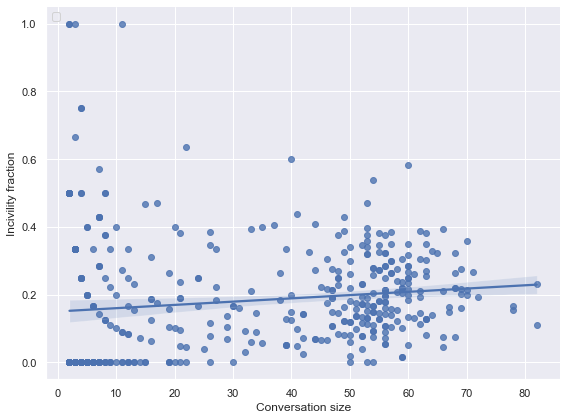

In [63]:
g = sns.lmplot(x="size", y="incivility_frac", data=inc_int_len_siz_df[["size", "incivility_frac"]], height=6, aspect=1.34, legend=True)

g.ax.set_ylabel("Incivility fraction")
g.ax.set_xlabel("Conversation size")
g.ax.legend(ncol=1, loc=2)
plt.tight_layout()

plt.savefig("./../"+output_path+"/figures/"+"_conv_size_incivility_frac_scatter.png", bbox_inches="tight")
plt.show()

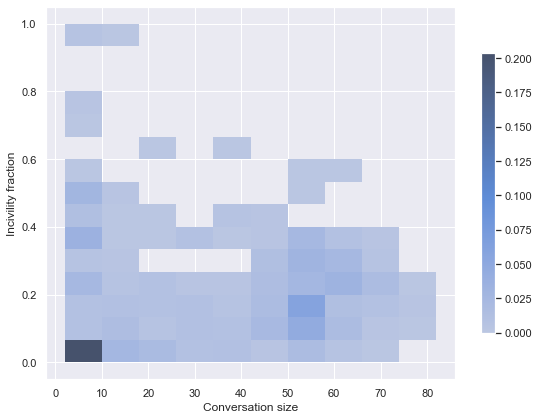

In [64]:
fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(x=inc_int_len_siz_df[["size", "incivility_frac"]]['size'], y=inc_int_len_siz_df[["size", "incivility_frac"]]['incivility_frac'],  stat="probability", cbar=True, cbar_kws=dict(shrink=.75))


ax.set_ylabel("Incivility fraction")
ax.set_xlabel("Conversation size")
# ax.set_xlim(0,85)
# ax.set_ylim(0,55)
plt.tight_layout()

plt.savefig("./../"+output_path+"/figures/"+"_conv_size_incivility_frac_heatmap.png", bbox_inches="tight")
plt.show()

No handles with labels found to put in legend.


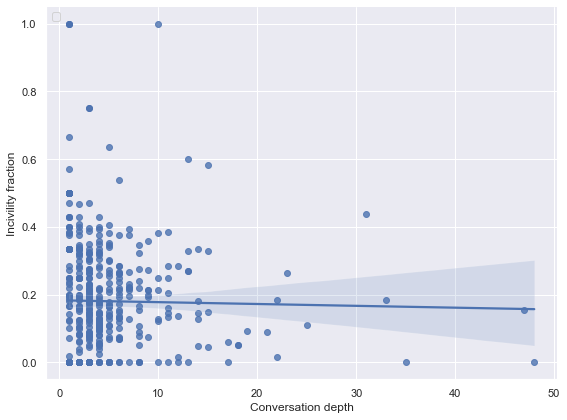

In [65]:
g = sns.lmplot(x="depth", y="incivility_frac", data=inc_int_len_siz_df[["depth", "incivility_frac"]], height=6, aspect=1.34, legend=True)

g.ax.set_ylabel("Incivility fraction")
g.ax.set_xlabel("Conversation depth")
g.ax.legend(ncol=1, loc=2)
plt.tight_layout()

plt.savefig("./../"+output_path+"/figures/"+"_conv_depth_incivility_frac_scatter.png", bbox_inches="tight")
plt.show()

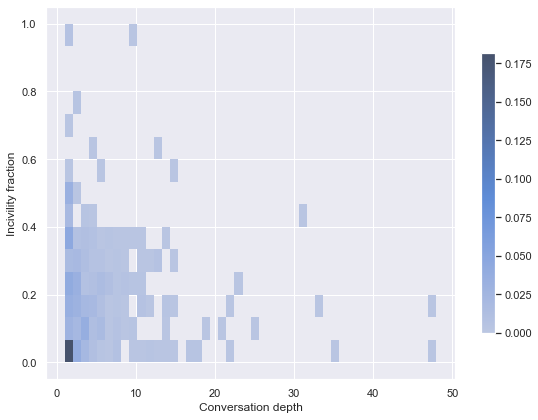

In [66]:
fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(x=inc_int_len_siz_df[["depth", "incivility_frac"]]['depth'], y=inc_int_len_siz_df[["depth", "incivility_frac"]]['incivility_frac'],  stat="probability", cbar=True, cbar_kws=dict(shrink=.75))


ax.set_ylabel("Incivility fraction")
ax.set_xlabel("Conversation depth")

plt.tight_layout()

plt.savefig("./../"+output_path+"/figures/"+"_conv_depth_incivility_frac_heatmap.png", bbox_inches="tight")
plt.show()

No handles with labels found to put in legend.


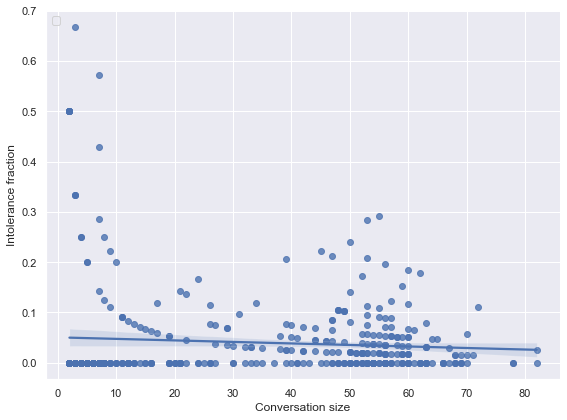

In [67]:
g = sns.lmplot(x="size", y="intolerance_frac", data=inc_int_len_siz_df[["size", "intolerance_frac"]], height=6, aspect=1.34, legend=True)

g.ax.set_ylabel("Intolerance fraction")
g.ax.set_xlabel("Conversation size")
g.ax.legend(ncol=1, loc=2)
plt.tight_layout()

plt.savefig("./../"+output_path+"/figures/"+"_conv_size_intolerance_frac_scatter.png", bbox_inches="tight")
plt.show()

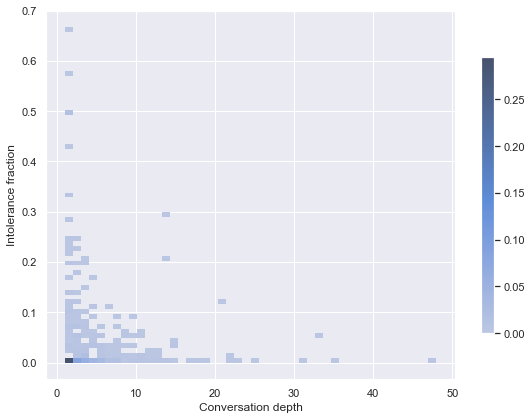

In [68]:
fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(x=inc_int_len_siz_df[["depth", "intolerance_frac"]]['depth'], y=inc_int_len_siz_df[["depth", "intolerance_frac"]]['intolerance_frac'],  stat="probability", cbar=True, cbar_kws=dict(shrink=.75))


ax.set_ylabel("Intolerance fraction")
ax.set_xlabel("Conversation depth")

plt.tight_layout()

plt.savefig("./../"+output_path+"/figures/"+"_conv_depth_intolerance_frac_heatmap.png", bbox_inches="tight")
plt.show()

No handles with labels found to put in legend.


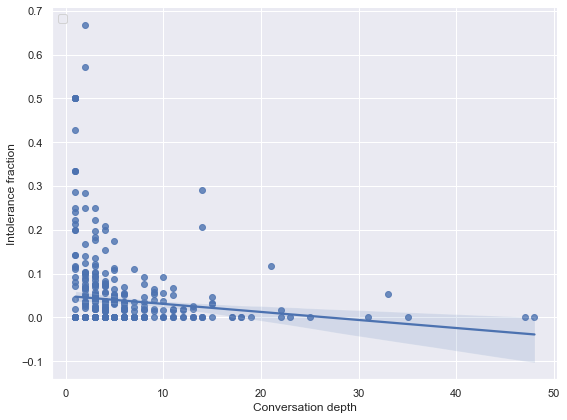

In [69]:
g = sns.lmplot(x="depth", y="intolerance_frac", data=inc_int_len_siz_df[["depth", "intolerance_frac"]], height=6, aspect=1.34, legend=True)

g.ax.set_ylabel("Intolerance fraction")
g.ax.set_xlabel("Conversation depth")
g.ax.legend(ncol=1, loc=2)
plt.tight_layout()

plt.savefig("./../"+output_path+"/figures/"+"_conv_depth_intolerance_frac_scatter.png", bbox_inches="tight")
plt.show()

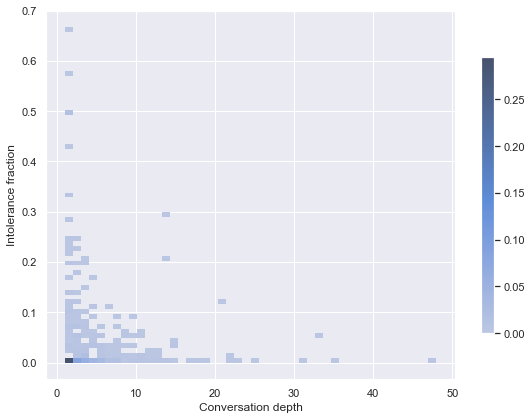

In [70]:
fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(x=inc_int_len_siz_df[["depth", "intolerance_frac"]]['depth'], y=inc_int_len_siz_df[["depth", "intolerance_frac"]]['intolerance_frac'],  stat="probability", cbar=True, cbar_kws=dict(shrink=.75))


ax.set_ylabel("Intolerance fraction")
ax.set_xlabel("Conversation depth")

plt.tight_layout()

plt.savefig("./../"+output_path+"/figures/"+"_conv_depth_intolerance_frac_heatmap.png", bbox_inches="tight")
plt.show()

In [88]:
nodes_dict = {}
nodes_neighbour_label = {}
distinct_labels = set()
dyadic_analysis_inc_int = {}

for node in relevant_modified_hyper_network_with_attributes.nodes:
    inc_lbl = "inc" if annotated_tweets_dict['incivility'][node] == 1 else "civ"
    int_lbl = "int" if annotated_tweets_dict['intolerance'][node] == 1 else "tol"
    node_lbl = inc_lbl + " and " + int_lbl
    
    distinct_labels.add(node_lbl)
    node_in_degree = relevant_modified_hyper_network_with_attributes.in_degree(node) if relevant_modified_hyper_network_with_attributes.in_degree(node) != 0 else 1
    nodes_dict[node_lbl] = nodes_dict.get(node_lbl, 0) + node_in_degree
    
    if relevant_modified_hyper_network_with_attributes.in_degree(node) == 0:
        nodes_neighbour_label[node_lbl] = nodes_neighbour_label.get(node_lbl, []) + ["X"]
    else:
        for edge in relevant_modified_hyper_network_with_attributes.in_edges(node):
            
            inc_lbl_neigh = "inc" if annotated_tweets_dict['incivility'][edge[0]] == 1 else "civ"
            int_lbl_neigh = "int" if annotated_tweets_dict['intolerance'][edge[0]] == 1 else "tol"
            node_lbl_neigh = inc_lbl_neigh + " and " + int_lbl_neigh
            
            nodes_neighbour_label[node_lbl] = nodes_neighbour_label.get(node_lbl, []) + [node_lbl_neigh]
            
            
givens = list(distinct_labels)
probs = list(distinct_labels) + ["X"]
for condition1 in givens:
    for condition2 in probs:
        dyadic_analysis_inc_int[condition2+"|"+condition1] = sum([1 for i in nodes_neighbour_label[condition1] if i == condition2]) / nodes_dict[condition1]

In [89]:
dyadic_analysis_inc_int_df = pd.DataFrame.from_dict(data=dyadic_analysis_inc_int, orient='index')
dyadic_analysis_inc_int_df = dyadic_analysis_inc_int_df.rename(columns={0:"Likelihood"})

In [90]:
cols, inds = set(), set()
for item in list(dyadic_analysis_inc_int_df.index):
    items = item.split("|")
    inds.add(items[0])
    cols.add(items[1])

In [91]:
dyadic_analysis_inc_int_df_heatmap = pd.DataFrame(columns=cols, index=inds, dtype="float")

for likelihood in dyadic_analysis_inc_int:
    indeces = likelihood.split("|")
    dyadic_analysis_inc_int_df_heatmap.loc[indeces[0]][indeces[1]] = dyadic_analysis_inc_int[likelihood]

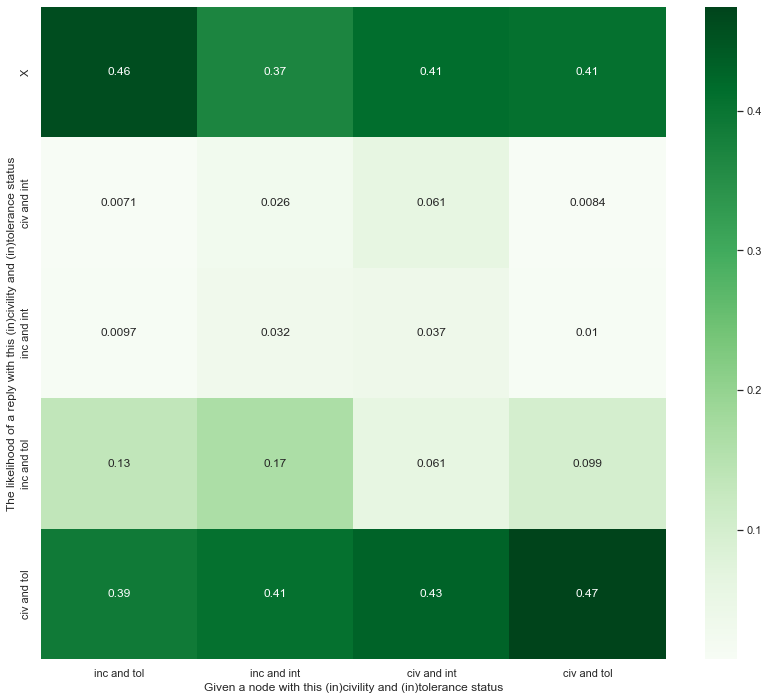

In [92]:
fig, ax = plt.subplots(figsize=(14,12)) 
ax = sns.heatmap(dyadic_analysis_inc_int_df_heatmap, annot=True, cmap="Greens")
ax.invert_yaxis()
plt.xlabel("Given a node with this (in)civility and (in)tolerance status")
plt.ylabel("The likelihood of a reply with this (in)civility and (in)tolerance status")
# ax.set_title("The likelihood of a reply with label Li to a node with label Lj (P(Li|Lj))")
# plt.savefig("./figures/"+subject+"_dyadic_interactions_hyper_network_heatmap.pdf", bbox_inches='tight')
plt.savefig("./../"+output_path+"/figures/"+"_dyadic_inc_int_heatmap.png", bbox_inches="tight")
plt.show()

In [93]:
nodes_dict = {}
nodes_neighbour_label = {}
distinct_labels = set()
dyadic_analysis_inc_vp = {}

for node in relevant_modified_hyper_network_with_attributes.nodes:
    inc_lbl = "inc" if annotated_tweets_dict['incivility'][node] == 1 else "civ"
    twt_lbl = annotated_tweets_dict['label'][node]
    node_lbl = inc_lbl + "__" + twt_lbl
    
    distinct_labels.add(node_lbl)
    node_in_degree = relevant_modified_hyper_network_with_attributes.in_degree(node) if relevant_modified_hyper_network_with_attributes.in_degree(node) != 0 else 1
    nodes_dict[node_lbl] = nodes_dict.get(node_lbl, 0) + node_in_degree
    
    if relevant_modified_hyper_network_with_attributes.in_degree(node) == 0:
        nodes_neighbour_label[node_lbl] = nodes_neighbour_label.get(node_lbl, []) + ["X"]
    else:
        for edge in relevant_modified_hyper_network_with_attributes.in_edges(node):
            
            inc_lbl_neigh = "inc" if annotated_tweets_dict['incivility'][edge[0]] == 1 else "civ"
            twt_lbl_neigh = annotated_tweets_dict['label'][edge[0]]
            node_lbl_neigh = inc_lbl_neigh + "__" + twt_lbl_neigh
            
            nodes_neighbour_label[node_lbl] = nodes_neighbour_label.get(node_lbl, []) + [node_lbl_neigh]
            
            
givens = list(distinct_labels)
probs = list(distinct_labels) + ["X"]
for condition1 in givens:
    for condition2 in probs:
        dyadic_analysis_inc_vp[condition2+"|"+condition1] = sum([1 for i in nodes_neighbour_label[condition1] if i == condition2]) / nodes_dict[condition1]

In [94]:
dyadic_analysis_inc_vp_df = pd.DataFrame.from_dict(data=dyadic_analysis_inc_vp, orient='index')
dyadic_analysis_inc_vp_df = dyadic_analysis_inc_vp_df.rename(columns={0:"Likelihood"})

In [95]:
cols, inds = set(), set()
for item in list(dyadic_analysis_inc_vp_df.index):
    items = item.split("|")
    inds.add(items[0])
    cols.add(items[1])

In [96]:
dyadic_analysis_inc_vp_df_heatmap = pd.DataFrame(columns=cols, index=inds, dtype="float")

for likelihood in dyadic_analysis_inc_vp:
    indeces = likelihood.split("|")
    dyadic_analysis_inc_vp_df_heatmap.loc[indeces[0]][indeces[1]] = dyadic_analysis_inc_vp[likelihood]

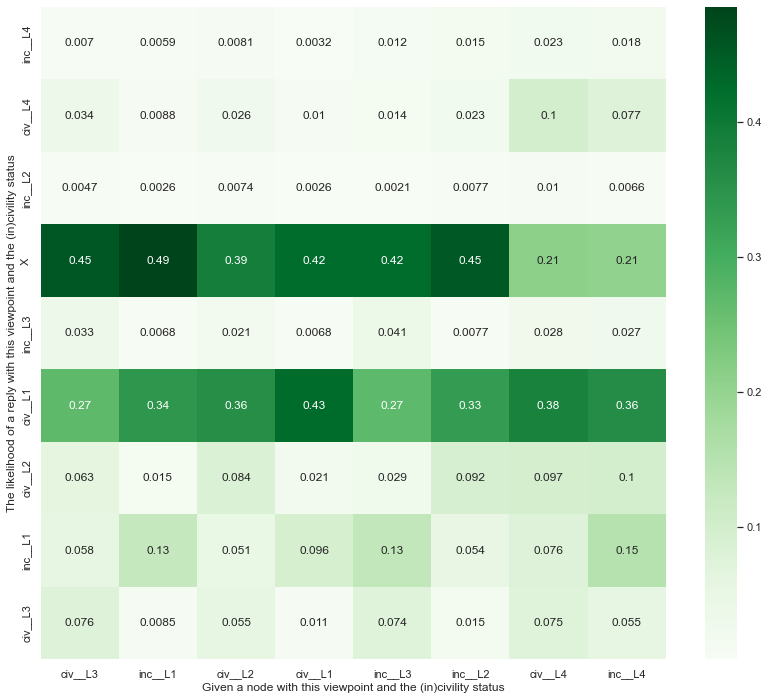

In [97]:
fig, ax = plt.subplots(figsize=(14,12)) 
ax = sns.heatmap(dyadic_analysis_inc_vp_df_heatmap, annot=True, cmap="Greens")
ax.invert_yaxis()
plt.xlabel("Given a node with this viewpoint and the (in)civility status")
plt.ylabel("The likelihood of a reply with this viewpoint and the (in)civility status")
# ax.set_title("The likelihood of a reply with label Li to a node with label Lj (P(Li|Lj))")
# plt.savefig("./figures/"+subject+"_dyadic_interactions_hyper_network_heatmap.pdf", bbox_inches='tight')
plt.savefig("./../"+output_path+"/figures/"+"_dyadic_inc_vp_heatmap.png", bbox_inches="tight")
plt.show()

In [98]:
nodes_dict = {}
nodes_neighbour_label = {}
distinct_labels = set()
dyadic_analysis_int_vp = {}

for node in relevant_modified_hyper_network_with_attributes.nodes:
    int_lbl = "int" if annotated_tweets_dict['intolerance'][node] == 1 else "tol"
    twt_lbl = annotated_tweets_dict['label'][node]
    node_lbl = int_lbl + "__" + twt_lbl
    
    distinct_labels.add(node_lbl)
    node_in_degree = relevant_modified_hyper_network_with_attributes.in_degree(node) if relevant_modified_hyper_network_with_attributes.in_degree(node) != 0 else 1
    nodes_dict[node_lbl] = nodes_dict.get(node_lbl, 0) + node_in_degree
    
    if relevant_modified_hyper_network_with_attributes.in_degree(node) == 0:
        nodes_neighbour_label[node_lbl] = nodes_neighbour_label.get(node_lbl, []) + ["X"]
    else:
        for edge in relevant_modified_hyper_network_with_attributes.in_edges(node):
            
            int_lbl_neigh = "int" if annotated_tweets_dict['intolerance'][edge[0]] == 1 else "tol"
            twt_lbl_neigh = annotated_tweets_dict['label'][edge[0]]
            node_lbl_neigh = int_lbl_neigh + "__" + twt_lbl_neigh
            
            nodes_neighbour_label[node_lbl] = nodes_neighbour_label.get(node_lbl, []) + [node_lbl_neigh]
            
            
givens = list(distinct_labels)
probs = list(distinct_labels) + ["X"]
for condition1 in givens:
    for condition2 in probs:
        dyadic_analysis_int_vp[condition2+"|"+condition1] = sum([1 for i in nodes_neighbour_label[condition1] if i == condition2]) / nodes_dict[condition1]

In [99]:
dyadic_analysis_int_vp_df = pd.DataFrame.from_dict(data=dyadic_analysis_int_vp, orient='index')
dyadic_analysis_int_vp_df = dyadic_analysis_int_vp_df.rename(columns={0:"Likelihood"})

In [100]:
cols, inds = set(), set()
for item in list(dyadic_analysis_int_vp_df.index):
    items = item.split("|")
    inds.add(items[0])
    cols.add(items[1])

In [101]:
dyadic_analysis_int_vp_df_heatmap = pd.DataFrame(columns=cols, index=inds, dtype="float")

for likelihood in dyadic_analysis_int_vp:
    indeces = likelihood.split("|")
    dyadic_analysis_int_vp_df_heatmap.loc[indeces[0]][indeces[1]] = dyadic_analysis_int_vp[likelihood]

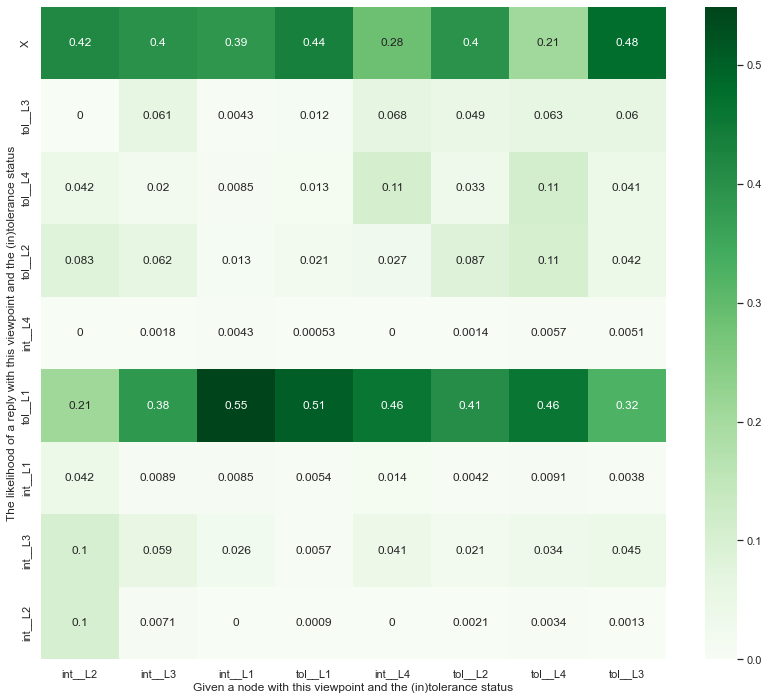

In [102]:
fig, ax = plt.subplots(figsize=(14,12)) 
ax = sns.heatmap(dyadic_analysis_int_vp_df_heatmap, annot=True, cmap="Greens")
ax.invert_yaxis()
plt.xlabel("Given a node with this viewpoint and the (in)tolerance status")
plt.ylabel("The likelihood of a reply with this viewpoint and the (in)tolerance status")
# ax.set_title("The likelihood of a reply with label Li to a node with label Lj (P(Li|Lj))")
# plt.savefig("./figures/"+subject+"_dyadic_interactions_hyper_network_heatmap.pdf", bbox_inches='tight')
plt.savefig("./../"+output_path+"/figures/"+"_dyadic_int_vp_heatmap.png", bbox_inches="tight")
plt.show()